In [49]:
import math
import random
import numpy

import torch
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

# Input

In [50]:
words = open('names.txt', 'r').read().splitlines()
print(f'{len(words)}')
words[:8]

32033


['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [51]:
len(words)

32033

lookup tables

In [52]:
# build the vocab of chars and lookup tables
# Q: what will be the vocab for word level language model?

chars = list('abcdefghijklmnopqrstuvwxyz')
stoi_lookup = {c: i+1 for i, c in enumerate(chars)}
stoi_lookup['.'] = 0
itos_lookups = {i: char for char, i in stoi_lookup.items()}
vocab_size = len(itos_lookups)
print(itos_lookups)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


### Dataset creation

Embeddings lookup table

in [Bengio et al](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf), 17k words were embeeded into 30 dims

we have to embed 27 chars into small dims, lets start with 2 dims embedding for now

Hidden & Output Layer

- What would be the input to this layer?

    the embedding have the shape [32, 3, 2] which means that we have 32 inputs and for each input we have three(one for each character) two dims embeddings => 3 * 2 = 6

- What would be the number of neurons, we can try it with different values, lets say 100 for now

Build the Dataset

-  both BOS and EOS are represented using '.'

- context - characters to be considered for the next prediction
    - what would be context for the first letter? just '.', the number of '.' will depend on the length of the context


- make sure to represent the EOS as well

In [63]:
block_size = 3 # context length

def build_dataset(words):
    # input and output
    X, Y = [], []
    for word in words:
        # print('word: ', word)
        context = [0] * block_size
        seq = word + '.'    # don't forget to add the . add the end

        for char in seq:
            X.append(context)
            # index of the character to be predicted
            y_idx = stoi_lookup[char]
            Y.append(y_idx)
            # print(''.join(itos_lookups[c] for c in context), '--->', itos_lookups[y_i])
            # update the context for the next sequence
            context = context[1:] + [y_idx]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print("shapes: ", X.shape, Y.shape)
    return X, Y


random.seed(42)
random.shuffle(words)

train_window_end = int(0.8*len(words))
val_window_end = int(0.9*len(words))

X_train, Y_train = build_dataset(words[:train_window_end])
X_val, Y_val = build_dataset(words[train_window_end:val_window_end])
X_test, Y_test = build_dataset(words[val_window_end:])

shapes:  torch.Size([182580, 3]) torch.Size([182580])
shapes:  torch.Size([22767, 3]) torch.Size([22767])
shapes:  torch.Size([22799, 3]) torch.Size([22799])


training(80%), val(10%), test(10%) splits 
 - training set is used for optimizing the params of the model
 - validation set is used for training the hyperparameters(hidden layer size, embedding size etc)
 - evaluating the performance of the model

### Build the Network

In [81]:
dim_embd = 10 # dimensionality of the character embedding vectors
n_hidden = 200 # number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, dim_embd),             generator=g)

W1 = torch.randn((dim_embd* block_size, n_hidden),  generator=g) * (5/3)/(dim_embd* block_size) ** 0.5
# b1 = torch.randn(n_hidden,                          generator=g) * 0.01

# multiplying by a small value so that the initial values for W2 are not high
# without this the loss would be very high for the first few passes 
# and those passes would be wasted in getting the loss down to a smaller value
W2 = torch.randn((n_hidden, vocab_size),            generator=g) * 0.01 
b2 = torch.randn(vocab_size,                        generator=g) * 0

# -------------- BATCH NORMALIZATION PRAMETERS --------------
# "scale and shift" batch normalization params
bn_gain = torch.ones((1, n_hidden))
bn_bias = torch.zeros((1, n_hidden))

# track running mean and stddev
running_bn_mean = torch.zeros((1, n_hidden)) # intialized for a gaussian dist => mean to 0
running_bn_std = torch.ones((1, n_hidden))   # intialized for a gaussian dist => stddev to 1
# ------------------------------------------------------------

params = [C, W1, W2, b2, bn_gain, bn_bias]
print(sum(p.nelement() for p in params))

# set the p.grad requires to true first so that we are able to get the grad for the params
for p in params:
    p.requires_grad = True

12097


### Train the Network

In [82]:
max_steps = 200000
batch_size = 32
losses_at_idx = []

for step in range(max_steps):
    # -------------- MINIBATCH construction --------------
    ix = torch.randint(0, X_train.shape[0], (batch_size, ), generator=g)
    Xb, Yb = X_train[ix], Y_train[ix]
    # -----------------------------------------------------

    # -------------------- FORWARD PASS -------------------
    emb = C[Xb] # embed the chars into vectors

    emb_cat = emb.view(emb.shape[0], -1) # vectors concatenation to make them 2D
    # ------ linear layer ------
    h_preact = emb_cat @ W1 # hidden layer pre-activation
    # ---------------------------

    # ------------ BATCH NORMALIZATION LAYER ------------
    bn_mean_ix = h_preact.mean(0, keepdim=True)
    bn_std_ix = h_preact.std(0, keepdim=True)
    
    # add batch normalization to make the h_preact normalized at initialisation
    # add "scale and shift" for the optimisation 
    h_preact = bn_gain * (h_preact - bn_mean_ix) / bn_std_ix + bn_bias

    # track running mean and stddv
    with torch.no_grad():
        running_bn_mean = 0.999 * running_bn_mean + 0.001 * bn_mean_ix
        running_bn_std = 0.999 * running_bn_std + 0.001 * bn_std_ix

    # ----------------------------------------------------

    # ------ NON LINEAR LAYER ------
    h = torch.tanh(h_preact)
    logits = h @ W2 + b2
    # only select the indices in the current mini batch
    loss = F.cross_entropy(logits, Yb)
    # print(f'{loss=}')
    # ------------------------------
    
    # ------ BACKWARD PASS ------
    # set the gradients to 0 - IMP
    for p in params:
        p.grad = None
    
    # calculate the gradients of the loss w.r.t params
    loss.backward()
    # -----------------------------
    l_rate = 0.1 if step < 100000 else 0.01 # learning rate 
    
    # update the params
    for p in params:
        p.data += -l_rate * p.grad

    # track stats
    if step % 10000 == 0: # print periodically
        print(f'{step:7d}/{max_steps:7d}:{loss.item():.4f}')
    
    losses_at_idx.append(loss.log10().item())
    

# print(f'{loss=}')

      0/ 200000:3.2856
  10000/ 200000:2.1340
  20000/ 200000:2.1373
  30000/ 200000:2.2285
  40000/ 200000:2.0133
  50000/ 200000:1.7307
  60000/ 200000:2.2741
  70000/ 200000:2.2340
  80000/ 200000:2.3828
  90000/ 200000:2.0722
 100000/ 200000:2.2072
 110000/ 200000:2.1703
 120000/ 200000:2.2788
 130000/ 200000:1.8803
 140000/ 200000:1.7875
 150000/ 200000:2.1805
 160000/ 200000:1.9339
 170000/ 200000:1.9587
 180000/ 200000:2.1038
 190000/ 200000:2.0363


activation function analyis

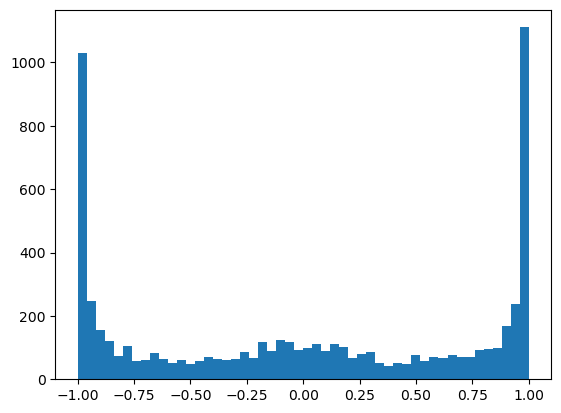

In [48]:
plt.hist(h.view(-1).tolist(), bins=50);

from the above histogram, we can see that the output of the activation function is saturated towards the ends, -1 and 1.

Why is this an issue?

- The graph of tanh becomes flat at -1 and 1 implying that when an input is passed through it, there would be very no impact on the output of the tanh, therefore there would be no impact on the loss. 

    - The weights and biases along with this tanh neuron do not impact the loss much, the gradient will vanish. 

If this is happening at initialization then we can simply multiply the weights and biases along it with a small factor.

To get a better understanding of what factors to choose, check out [NN Intialization](https://github.com/priyamore/language-modeling/blob/main/how_to_intialize_nn.ipynb)) 

Plot losses per step

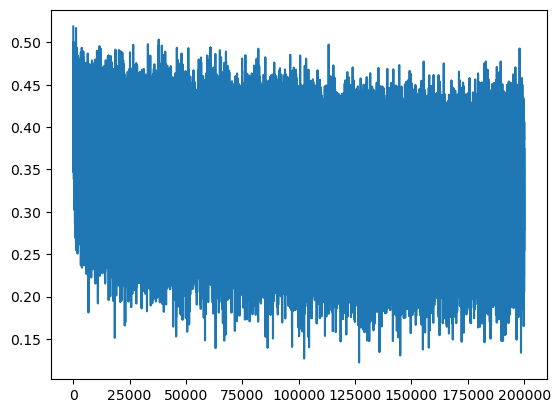

In [79]:
plt.plot(losses_at_idx)

Calculate the training and validation losses

In [83]:
# disable gradient tracking with decorator - 
# this decorator sets the tensors in the function that follows to requires_grad = False
@torch.no_grad() 
def split_losses(split_name):
    x, y = {
        'train': (X_train, Y_train),
        'val': (X_val, Y_val),
        'test': (X_test, Y_test)
    }[split_name]

    emb = C[x] # (N, block_size, dim_emb)
    emb_cat = emb.view(emb.shape[0], -1) # concat into (N, block_size * dim_emb)
    h_preact = emb_cat @ W1 + b1 # hidden layer pre-activation
    h_preact = bn_gain * (h_preact - running_bn_mean) /running_bn_std + bn_bias
    h = torch.tanh(h_preact) # (N, n_hidden)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split_name, loss.item())

split_losses('train')
split_losses('val')

train 2.065722942352295
val 2.109656810760498


Sampling from the model

In [38]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size

    while True:
        # forward pass 
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        prob = F.softmax(logits, dim=1)
        ix = torch.multinomial(prob, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    
    print(''.join(itos_lookups[i] for i in out))

carmah.
ambrie.
khy.
mili.
tatyanna.
sane.
rahnie.
delynn.
jareei.
ner.
kiah.
maiha.
kaleigh.
ham.
jois.
quint.
sulie.
alianni.
wanell.
dearynn.


In [108]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        # add gain here or handle it while building the network
        self.weight = torch.randn((fan_in, fan_out), generator=g) /fan_in ** 0.5 # fan_in ** 0.5 kaiming init for good initalization
        self.bias = torch.zeros(fan_out) if bias else None
    
    # self function
    def __call__(self, x):
        self.out = x @ self.weight # y = w * x + b
        if self.bias is not None:
            self.out += self.bias

        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    

In [109]:
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # batch norm params
        self.gamma = torch.ones(dim) # scale factor
        self.beta = torch.zeros(dim) # shift
        # buffers for tracking running mean and var
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    def __call__(self, x):
        # forward pass
        if self.training:
            # reset for every mini batch
            x_mean = x.mean(0, keepdim=True)
            x_var = x.var(0, keepdim=True)
        else:
            x_mean = self.running_mean
            x_var = self.running_var


        x_hat = (x-x_mean)/torch.sqrt(x_var+self.eps) # kaiming init
        self.out = self.gamma * x_hat + self.beta

        # update the running buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * x_mean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * x_var

        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


In [110]:
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

Build the Network

In [163]:
dim_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, dim_embd), generator=g)
layers = [
    Linear(dim_embd * block_size, n_hidden), Tanh(),
    Linear(             n_hidden, n_hidden), Tanh(),
    Linear(             n_hidden, n_hidden), Tanh(),
    Linear(             n_hidden, n_hidden), Tanh(),
    Linear(             n_hidden, n_hidden), Tanh(),
    Linear(             n_hidden, vocab_size),
]

with torch.no_grad():
    layers[-1].weight *= 0.1
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

params = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in params))

for p in params:
    p.requires_grad = True


46497


Training

In [164]:
max_steps = 200000
batch_size = 32
losses_at_idx = []
up_d_ratio =[]

for step in range(max_steps):
    # -------------- MINIBATCH construction --------------
    ix = torch.randint(0, X_train.shape[0], (batch_size, ), generator=g)
    Xb, Yb = X_train[ix], Y_train[ix]
    # -----------------------------------------------------

    # -------------------- FORWARD PASS -------------------
    emb = C[Xb] # embed the chars into vectors

    x = emb.view(emb.shape[0], -1) # vectors concatenation to make them 2D
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)
    
    # ------ BACKWARD PASS ------
    for layer in layers:
        layer.out.retain_grad() # retain the gradients of the output
    # set the gradients to 0 - IMP
    for p in params:
        p.grad = None
    loss.backward() # calculate the gradients of the loss w.r.t params
    # -----------------------------
    l_rate = 0.1 if step < 100000 else 0.01 # learning rate 
    
    # update the params
    for p in params:
        p.data += -l_rate * p.grad

    # track stats
    if step % 10000 == 0: # print periodically
        print(f'{step:7d}/{max_steps:7d}:{loss.item():.4f}')
    
    losses_at_idx.append(loss.log10().item())
    with torch.no_grad():
        up_d_ratio.append([(l_rate*p.grad.std()/p.data.std()).log10().item() for p in params])
    if step >= 1000:
        break

# print(f'{loss=}')

      0/ 200000:3.3245


Visualize Statistics

Visualize Activations 

- Try to visualise all types of layers, in this case tanh and linear
- How does the std distribution change for different values of gain?
- When does the saturation stablilise?
    - especially for tanh, notice saturation because the values in the saturation are at the risk of not recieving any gradients in the future due to the flat area, we dont want a high saturated graph
- How is the distribution changing for each layer, if it does?

layer 1 (      Tanh): mean -0.06, std 0.76, saturated: 21.53%
layer 3 (      Tanh): mean +0.01, std 0.72, saturated: 11.72%
layer 5 (      Tanh): mean -0.02, std 0.73, saturated: 13.75%
layer 7 (      Tanh): mean -0.02, std 0.73, saturated: 14.25%
layer 9 (      Tanh): mean -0.01, std 0.70, saturated: 10.31%


Text(0.5, 1.0, 'tanh activation distribution')

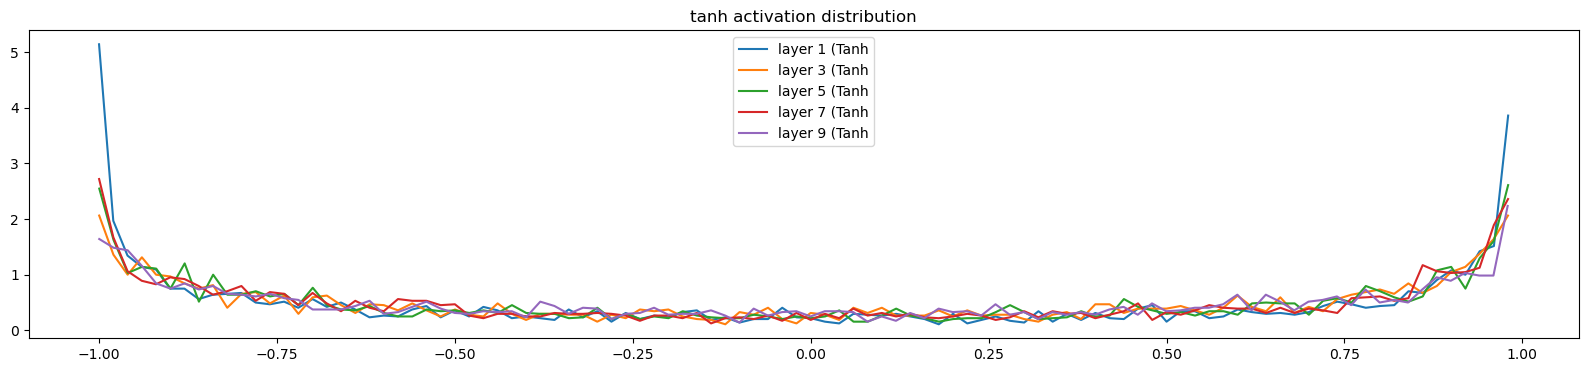

In [165]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]): # except the softmax layer
    if isinstance(layer, Tanh):
        out = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, out.mean(), out.std(), (out.abs() > 0.97).float().mean() * 100))
        h_y, h_x = torch.histogram(out, density=True)
        plt.plot(h_x[:-1].detach(), h_y.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
    
plt.legend(legends);
plt.title('tanh activation distribution')

Visualize tanh Gradients

For all the layers, for different gain
- are the gradients shrinking or exploding? 
- are the gradients stabilising?

layer 1 (      Tanh): mean -0.000048, std 3.441710e-03
layer 3 (      Tanh): mean -0.000058, std 3.294970e-03
layer 5 (      Tanh): mean +0.000016, std 3.042348e-03
layer 7 (      Tanh): mean -0.000035, std 2.901084e-03
layer 9 (      Tanh): mean +0.000016, std 2.376518e-03


Text(0.5, 1.0, 'tanh gradient distribution')

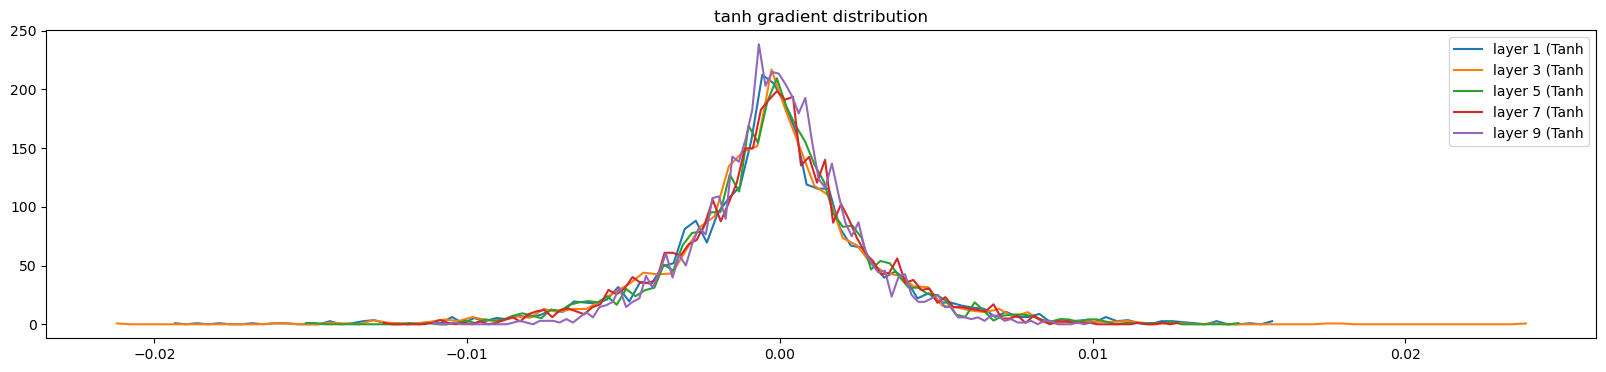

In [166]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]): # except output layer
    if isinstance(layer, Tanh):
        grad = layer.out.grad
        # due to the gain the gradients should be stable
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, grad.mean(), grad.std()))
        h_y, h_x = torch.histogram(grad, density=True)
        plt.plot(h_x[:-1].detach(), h_y.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
    
plt.legend(legends);
plt.title('tanh gradient distribution')

Visualize weights gradients

grad to data ratio of the weights can be informative for undertsanding how much of a step up is occuring in the data, think of x+h, or x-h, in other words it can tell us how gradients have changed w.r.t to data

weight   (27, 10) | mean -0.000778 | std 1.119964e-02 | grad:data ratio 1.119103e-02
weight  (30, 100) | mean -0.000006 | std 9.959943e-03 | grad:data ratio 3.182398e-02
weight (100, 100) | mean +0.000035 | std 8.234476e-03 | grad:data ratio 4.900465e-02
weight (100, 100) | mean +0.000091 | std 7.020391e-03 | grad:data ratio 4.141925e-02
weight (100, 100) | mean -0.000049 | std 6.007064e-03 | grad:data ratio 3.559794e-02
weight (100, 100) | mean -0.000000 | std 4.967415e-03 | grad:data ratio 2.949064e-02
weight  (100, 27) | mean +0.000000 | std 2.013820e-02 | grad:data ratio 2.855440e-01


Text(0.5, 1.0, 'weights gradient distribution')

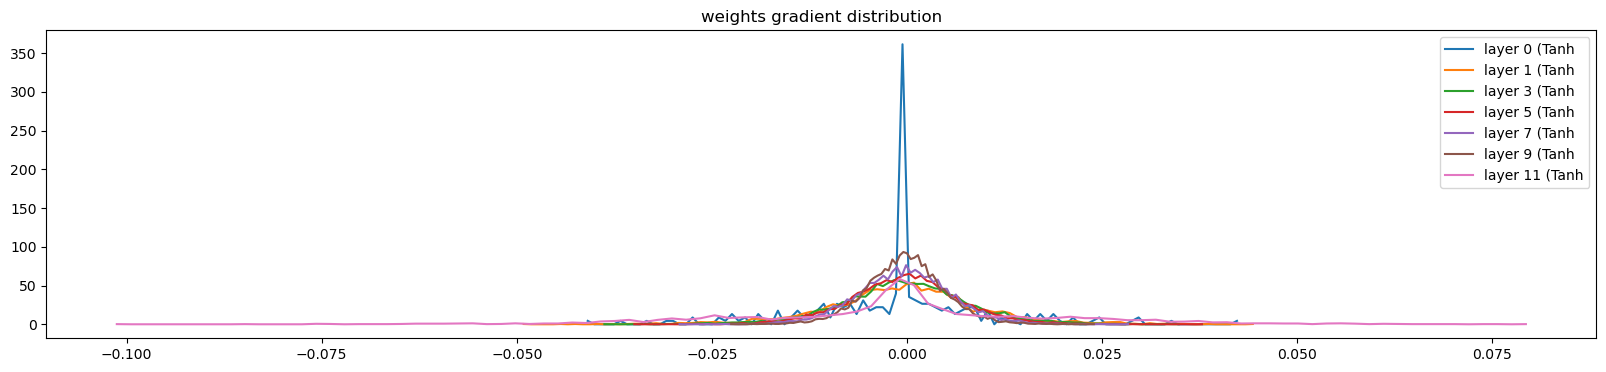

In [167]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(params):
    grad = p.grad
    if p.ndim == 2:
       
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' %(tuple(p.shape), grad.mean(), grad.std(), grad.std()/p.std()))
        h_y, h_x = torch.histogram(grad, density=True)
        plt.plot(h_x[:-1].detach(), h_y.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
    
plt.legend(legends);
plt.title('weights gradient distribution')

Visualize Data Update to data Ratio
- try different learning rates, if the updates are too low(lower than 1e-3), we can try a higher one, this analysis can give us an idea about choosing a good learning rate
- are there layers which are learning too fast or too slow?

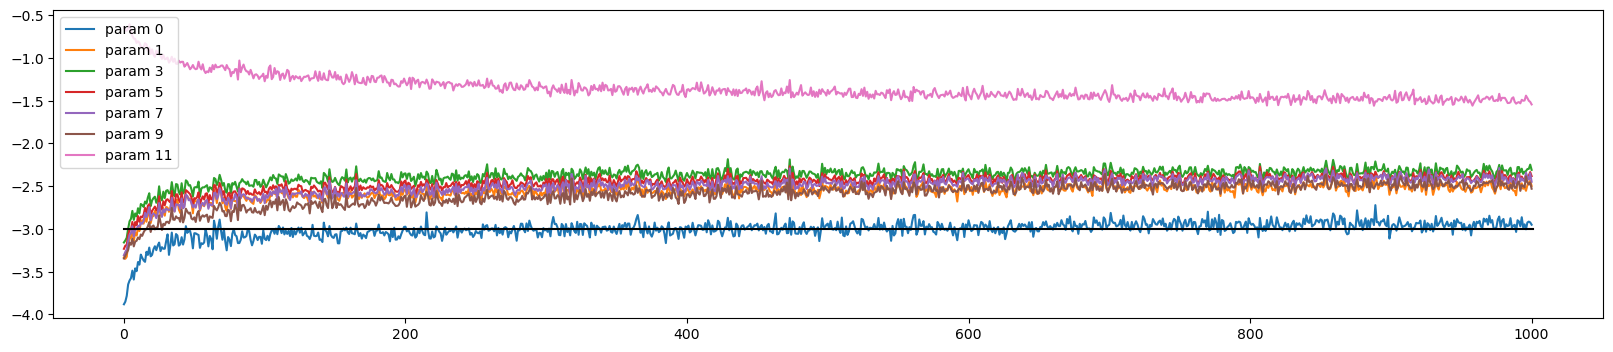

In [170]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(params):
    if p.ndim == 2:
        plt.plot([up_d_ratio[j][i] for j in range(len(up_d_ratio))])
        legends.append('param %d' %i)
# the approximate ideal value, which is 1e-3, the update shouldn't be greater than 1/1000 of the data
plt.plot([0, len(up_d_ratio)], [-3, -3], 'k')
plt.legend(legends);

 __Reference: [Neural Networks: Zero to Hero by **Anderj Karpathy**](https://youtu.be/VMj-3S1tku0?si=nt0sYb9Rs2g4qApr)__